# MXNet Basics - Linear Regression using MXNet

In [1]:
import mxnet as mx
import numpy as np

## Preparing the Data

MXNet uses data in the form of Data **Iterators**. The code below illustrates how to encode a dataset into an iterator that MXNet can use. The data used in the example is made up of 2d data points with corresponding integer labels. The function we are trying to learn is:

 y = x<sub>1</sub>  +  2x<sub>2</sub> ,
 
 where (x<sub>1</sub>,x<sub>2</sub>) is one training data point and y is the corresponding label

In [2]:
#Training data
train_data = np.array([[1,2],[3,4],[5,6],[3,2],[7,1],[6,9]])
train_label = np.array([5,11,17,7,9,24])
batch_size = 1

#Evaluation Data
eval_data = np.array([[7,2],[6,10],[12,2]])
eval_label = np.array([11,26,16])


Once we have the data ready, we need to put it into an iterator and specify parameters such as the 'batch_size', and 'shuffle' which will determine the size of data the iterator feeds during each pass, and whether or not the data will be shuffled respectively.

In [3]:
train_iter = mx.io.NDArrayIter(train_data,train_label, batch_size, shuffle=True,label_name='lin_reg_label')
eval_iter = mx.io.NDArrayIter(eval_data, eval_label, batch_size, shuffle=False)

In the above example, we have made use of NDArrayIter, which is used to iterate over numpy arrays. In general, there are many different types of iterators in MXNet based on the type of data you will be using. Their complete documentation can be found at:  http://mxnet.io/api/python/io.html

## MXNet Classes

1. Model Class: The model class in MXNet is used to define the overall entity of the model. It contains the variable we want to minimize, the training data and labels, and some additional parameters such as the learning rate and optimization algorithm are defined at the model level.

2. Symbols: The actual MXNet network is defined using symbols. MXNet has different types of symbols, including data placeholders, neural network layers, and loss function symbols based on our requirement.

3. IO: The IO class as we already saw works on the data, and carries out operations like breaking the data into batches and shuffling it.

## Defining the Model

MXNet uses **Symbols** for defining a model. Symbols are the building blocks of the model and compose various components of the model. Some of the parts symbols are used to define are:
1. Variables: A variable is a placeholder for future data. This symbol is used to define a spot which will be filled with training data/labels in the future when we are trying to train the model.
2. Neural Network Layers: The layers of a network or any other type of model are also defined by Symbols. Such a *symbol* takes one of the previous symbols as its input, does some transformation on them, and creates an output. One such example is the "Fully Connected" symbol which specifies a fully connected layer of a network. 
3. Output Symbols: Output symbols are MXNet's way of defining a loss. They are suffixed with the work "Output" (eg. the SoftmaxOutput layer" . You can also create your [own loss][https://github.com/dmlc/mxnet/blob/5b6a0eeee174f28ff0272d17748513ecd52a9ebe/docs/tutorials/r/CustomLossFunction.md#how-to-use-your-own-loss-function] Some examples of existing losses are: LinearRegressionOutput, which computes the l2-loss between it's input symbol and the actual labels provided to it, SoftmaxOutput, which computs the categorical cross-entropy. 

The ones described above, and other symbols are chained one after the other, servng as input to one another to create the network topology. More information about the different types of symbols can be found [here][http://mxnet.io/api/python/symbol.html]
    
    
   

In [4]:
X = mx.sym.Variable('data')
Y = mx.symbol.Variable('lin_reg_label')
fully_connected_layer  = mx.sym.FullyConnected(data=X, name='fc1', num_hidden = 1)
lro = mx.sym.LinearRegressionOutput(data=fully_connected_layer, label=Y, name="lro")

The above network uses the following layers:

1. FullyConnected: The fully connected symbol represents a fully connected layer of a neural network (without any activation being applied), which in essence, is just a linear regression on the input attributes. It takes the following parameters:
            a. data: Input to the layer (specify the symbol whose output should be fed here)
            b. num_hidden: Number of hidden dimension which specifies the size of the output of the layer
    
    
2. Linear Regression Output: Output layers in MXNet aim at implementing a loss. In our example, the Linear Regression Output layer is used which specifies that an l2 loss needs to be applied against it's input and the actual labels provided to this layer. The parameters to this layer are:
            a. data: Input to this layer (specify the symbol whose output should be fed here)
            b. Label: The training label against whom we will compare the input to the layer for calculation of l2 loss

**Note - *Naming Convention*: the label variable's name should be the same as the label_name parameter passed to your training data iterator. The default value of this is 'softmax_label', but we have updated it to lin_reg_label in this tutorial as you can see in Y = mx.symbol.Variable('lin_reg_label') and train_iter = mx.io.NDArrayIter(..., label_name="lin_reg_label")**

Finally, the network is stored into a *Module*, where you define the symbol who's value is to be minimised (in our case, lro or the lin_reg_output"), the learning rate to be used while optimization and the number of epochs we want to train our model on.

In [5]:
model = mx.mod.Module(
    symbol = lro ,
    data_names=['data'], 
    label_names = ['lin_reg_label']# network structure    
)

We can plot the network we have created in order to visualize it.

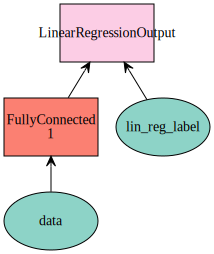

In [6]:
mx.viz.plot_network(symbol=lro)

## Training the model

Once we have defined the model structure, the next step is to train the parameters of the model to fit the training data. This is done by using the **fit()** function of the **Module** class.

In [7]:
model.fit(train_iter, eval_iter,
            optimizer_params={'learning_rate':0.01, 'momentum': 0.9},
            num_epoch=1000,
            batch_end_callback = mx.callback.Speedometer(batch_size, 2))

## Using a trained model: (Testing and Inference) 

Once we have a trained model, we can do multiple things on it. We can use it for inference, we can evaluate the trained model on test data. This is shown below.

In [8]:
#Inference
model.predict(eval_iter).asnumpy()

array([[ 11.],
       [ 26.],
       [ 16.]], dtype=float32)

We can also evaluate our model for some metric. In this example, we are evaulating our model's mean squared error on the evaluation data.

In [9]:
#Evaluation
metric = mx.metric.MSE()
model.score(eval_iter, metric)

[('mse', 0.0)]

Let us try to add some noise to the evaluation data and see how the MSE changes

In [10]:
#Evaluation Data
eval_data = np.array([[7,2],[6,10],[12,2]])
eval_label = np.array([11.1,26.1,16.1]) #Adding 0.1 to each of the values 
eval_iter = mx.io.NDArrayIter(eval_data, eval_label, batch_size, shuffle=False)

model.score(eval_iter, metric)

[('mse', 0.010000076144933701)]

Finally, you can create your own metrics and use it to evauate your model. More information on metrics here: http://mxnet-test.readthedocs.io/en/latest/api/metric.html